In [1]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math
from scipy.sparse import csr_matrix
import time

# CPFM Matrix Scaling MinRES Performance

The $2^{nd}$ step of the CPFM algorithm requires solving $\nabla^2 \mathbb{\phi} = c \rho$ for $\phi$ where $c \in \mathbb{R}$. Using central-in-space finite difference discretization, this equation can then be expressed as

$$\frac{1}{a^2} {\bf{A}} \phi = c \rho$$

where $\bf{A}$ is the Laplacian discretization matrix. Since $a :=$ `dx` $=$ `dy`, the assumption is that $0 < a < 1$, and thus $0 < \frac{1}{a^2} << 1$. Therefore, it is of interest to determine the MinRES solver speed regarding whether to scale $\bf{A}$ by $0 < \frac{1}{a^2} << 1$ or $c \rho$ by $a^2$. These will be called LHS scaling and RHS scaling respectively.

**Question :** Another test concerns a happy medium of redefining the equation as $\frac{1}{a} {\bf{A}} \phi = a c \rho$, called MHS which is made up. 


In [2]:
# Callback functions required to see number of iterations 
    # from https://stackoverflow.com/questions/29747043/retrieving-number-of-iterations-that-ran-for-sparse-linear-solver-in-scipy

def iterations_minres(A, b):
    num_iters = 0
    
    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x,status = scipy.sparse.linalg.minres(A, b, tol=1e-10, callback=callback)
    return x,status,num_iters

## For 2D

The `laplace_matrix_2D_RD()` function from the `CPFM_2D.py` module is used to create the Laplacian discretization matrix.

In [3]:
def laplace_matrix_2D_RD(Nx, Ny):
    """
    Creates the 2D Laplacian discretization matrix for a rectangular domain,
        thereby allowing for cases where Nx =/= Ny 
    Input: Nx & Ny (int), number of grid points on x- & y-axes
    Output: A_matrix (float array), 2D Laplacian discretization matrix
    """
    # initialize the Laplacian discretization matrix
    A_matrix = np.zeros((Nx*Ny, Nx*Ny))
    
    # iterate over the main diagonal
    for i in range(Nx*Ny):
        
        A_matrix[i][i] = -4 # coefficient for current cell x_i,j 
        
        if (i > 0):
            A_matrix[i-1][i] = 1 # coefficient for right neighbor x_i+1,j 
            
            if (((i + 1) % Ny == 1) and (i < Nx * Ny - 1)):
                A_matrix[i-1][i] = 0 # remove non-existent right neighbor x_i+1,j 
                                        # when reaching the end of a row       
        if (i < Nx * Ny) and (i > 0):
            A_matrix[i][i-1] = 1 # coefficient for left neighbor x_i-1,j 
            
        if (((i + 1) % Ny == 1) and (i > 2)):
            A_matrix[i][i-1] = 0 # remove non-existent left neighbor x_i-1,j 
                                        # when reaching the end of a row
                
    # np.diag() to add coefficients for top (x_i,j-1) and bottom (x_i,j+1) neighbors respectively       
    A_matrix += np.diag(np.ones(Nx * Ny - Ny), -Ny) + np.diag(np.ones(Nx * Ny - Ny), Ny)
  
    return A_matrix

In [4]:
dimension_list = [10, 20, 30, 40, 50, 70, 80, 100, 120, 140]

# define different a's
a_1 = 1.0
a_2 = 0.01
a_3 = 0.0001

# initialize plotting arrays
Na_array = np.array([])
iter_square_LHS_1 = np.array([])  # LHS scaling, a_1
time_square_LHS_1 = np.array([])
e_RMS_square_LHS_1 = np.array([])
iter_square_MHS_1 = np.array([])  # MHS scaling, a_1
time_square_MHS_1 = np.array([])
e_RMS_square_MHS_1 = np.array([])
iter_square_RHS_1 = np.array([])  # RHS scaling, a_1
time_square_RHS_1 = np.array([])
e_RMS_square_RHS_1 = np.array([])
iter_square_LHS_2 = np.array([])  # LHS scaling, a_2
time_square_LHS_2 = np.array([])
e_RMS_square_LHS_2 = np.array([])
iter_square_MHS_2 = np.array([])  # MHS scaling, a_2
time_square_MHS_2 = np.array([])
e_RMS_square_MHS_2 = np.array([])
iter_square_RHS_2 = np.array([])  # RHS scaling, a_2
time_square_RHS_2 = np.array([])
e_RMS_square_RHS_2 = np.array([])
iter_square_LHS_3 = np.array([])  # LHS scaling, a_3
time_square_LHS_3 = np.array([])
e_RMS_square_LHS_3 = np.array([])
iter_square_MHS_3 = np.array([])  # MHS scaling, a_3
time_square_MHS_3 = np.array([])
e_RMS_square_MHS_3 = np.array([])
iter_square_RHS_3 = np.array([])  # RHS scaling, a_3
time_square_RHS_3 = np.array([])
e_RMS_square_RHS_3 = np.array([])   

for i in range(len(dimension_list)):
    
    Na = dimension_list[i]
    
    # construct random RHS vector
    vec_RHS = np.random.rand(Na**2)
    
    # construct sparsely stored square domain Laplacian discretization matrices
    A_square = laplace_matrix_2D_RD(Na, Na)
    A_square_LHS_1 = (1/a_1**2) * scipy.sparse.bsr_matrix(A_square) # LHS scaling, a_1
    A_square_LHS_2 = (1/a_2**2) * scipy.sparse.coo_matrix(A_square) # LHS scaling, a_2
    A_square_LHS_3 = (1/a_3**2) * scipy.sparse.csc_matrix(A_square) # LHS scaling, a_3
    A_square_MHS_1 = (1/a_1) * scipy.sparse.bsr_matrix(A_square) # MHS scaling, a_1
    A_square_MHS_2 = (1/a_2) * scipy.sparse.coo_matrix(A_square) # MHS scaling, a_2
    A_square_MHS_3 = (1/a_3) * scipy.sparse.csc_matrix(A_square) # MHS scaling, a_3
    A_square_RHS = scipy.sparse.csc_matrix(A_square) # RHS scaling, A not dependent on a
    
    # Data generation/collection portion : 
    Na_array = np.append(Na_array, Na)
    
    
    # For LHS 1:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_LHS_1, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_LHS_1 @ solution_minres)**2))
    
    iter_square_LHS_1 = np.append(iter_square_LHS_1, iter_minres)
    time_square_LHS_1 = np.append(time_square_LHS_1, end - start)
    e_RMS_square_LHS_1 = np.append(e_RMS_square_LHS_1, e_RMS)
    
    # For LHS 2:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_LHS_2, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_LHS_2 @ solution_minres)**2))
    
    iter_square_LHS_2 = np.append(iter_square_LHS_2, iter_minres)
    time_square_LHS_2 = np.append(time_square_LHS_2, end - start)
    e_RMS_square_LHS_2 = np.append(e_RMS_square_LHS_2, e_RMS)
    
    # For LHS 3:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_LHS_3, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_LHS_3 @ solution_minres)**2))
    
    iter_square_LHS_3 = np.append(iter_square_LHS_3, iter_minres)
    time_square_LHS_3 = np.append(time_square_LHS_3, end - start)
    e_RMS_square_LHS_3 = np.append(e_RMS_square_LHS_3, e_RMS)
    
    # For MHS 1:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_MHS_1, a_1 * vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_MHS_1 @ solution_minres)**2))
    
    iter_square_MHS_1 = np.append(iter_square_MHS_1, iter_minres)
    time_square_MHS_1 = np.append(time_square_MHS_1, end - start)
    e_RMS_square_MHS_1 = np.append(e_RMS_square_MHS_1, e_RMS)
    
    # For MHS 2:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_MHS_2, a_2 * vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_MHS_2 @ solution_minres)**2))
    
    iter_square_MHS_2 = np.append(iter_square_MHS_2, iter_minres)
    time_square_MHS_2 = np.append(time_square_MHS_2, end - start)
    e_RMS_square_MHS_2 = np.append(e_RMS_square_MHS_2, e_RMS)
    
    # For MHS 3:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_MHS_3, a_3 * vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_MHS_3 @ solution_minres)**2))
    
    iter_square_MHS_3 = np.append(iter_square_MHS_3, iter_minres)
    time_square_MHS_3 = np.append(time_square_MHS_3, end - start)
    e_RMS_square_MHS_3 = np.append(e_RMS_square_MHS_3, e_RMS)
    
    # For RHS 1:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_RHS, a_1**2 * vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_RHS @ solution_minres)**2))
    
    iter_square_RHS_1 = np.append(iter_square_RHS_1, iter_minres)
    time_square_RHS_1 = np.append(time_square_RHS_1, end - start)
    e_RMS_square_RHS_1 = np.append(e_RMS_square_RHS_1, e_RMS)
    
    # For RHS 2:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_RHS, a_2**2 * vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_RHS @ solution_minres)**2))
    
    iter_square_RHS_2 = np.append(iter_square_RHS_2, iter_minres)
    time_square_RHS_2 = np.append(time_square_RHS_2, end - start)
    e_RMS_square_RHS_2 = np.append(e_RMS_square_RHS_2, e_RMS)
    
    # For RHS 3:
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_RHS, a_3**2 * vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_RHS @ solution_minres)**2))
    
    iter_square_RHS_3 = np.append(iter_square_RHS_3, iter_minres)
    time_square_RHS_3 = np.append(time_square_RHS_3, end - start)
    e_RMS_square_RHS_3 = np.append(e_RMS_square_RHS_3, e_RMS)
    

## Elapsed Time plots

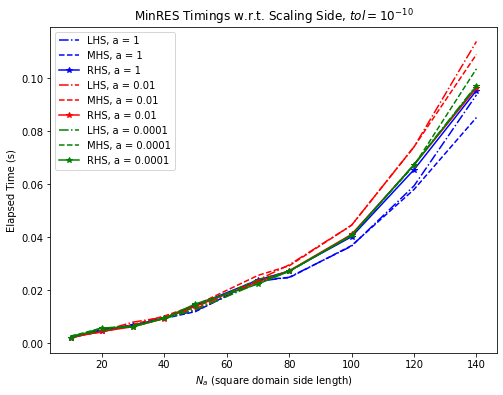

In [16]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_LHS_1, '-.b', Na_array, time_square_MHS_1, '--b', Na_array, time_square_RHS_1, '-*b', 
         Na_array, time_square_LHS_2, '-.r', Na_array, time_square_MHS_2, '--r', Na_array, time_square_RHS_2, '-*r',
         Na_array, time_square_LHS_3, '-.g', Na_array, time_square_MHS_3, '--g', Na_array, time_square_RHS_3, '-*g')
    
plt.title(r"MinRES Timings w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 1", "RHS, a = 1", 
            "LHS, a = 0.01", "MHS, a = 0.01", "RHS, a = 0.01", 
            "LHS, a = 0.0001", "MHS, a = 0.0001", "RHS, a = 0.0001"])


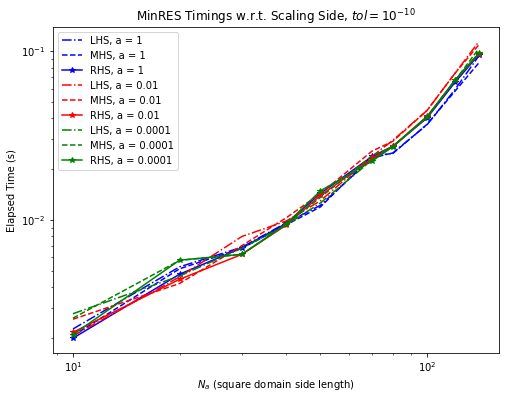

In [17]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_LHS_1, '-.b', Na_array, time_square_MHS_1, '--b', Na_array, time_square_RHS_1, '-*b', 
         Na_array, time_square_LHS_2, '-.r', Na_array, time_square_MHS_2, '--r', Na_array, time_square_RHS_2, '-*r',
         Na_array, time_square_LHS_3, '-.g', Na_array, time_square_MHS_3, '--g', Na_array, time_square_RHS_3, '-*g')
    
plt.title(r"MinRES Timings w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 1", "RHS, a = 1", 
            "LHS, a = 0.01", "MHS, a = 0.01", "RHS, a = 0.01", 
            "LHS, a = 0.0001", "MHS, a = 0.0001", "RHS, a = 0.0001"])


## # of Iterations plots

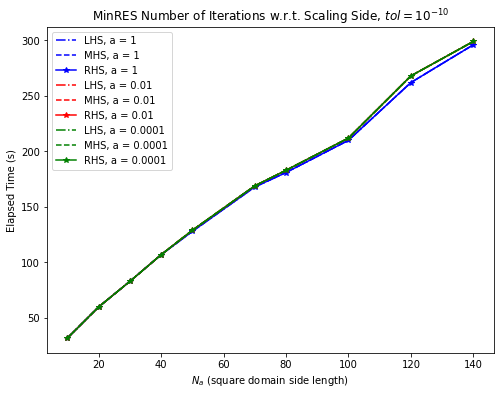

In [20]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, iter_square_LHS_1, '-.b', Na_array, iter_square_MHS_1, '--b', Na_array, iter_square_RHS_1, '-*b', 
         Na_array, iter_square_LHS_2, '-.r', Na_array, iter_square_MHS_2, '--r', Na_array, iter_square_RHS_2, '-*r',
         Na_array, iter_square_LHS_3, '-.g', Na_array, iter_square_MHS_3, '--g', Na_array, iter_square_RHS_3, '-*g')
    
plt.title(r"MinRES Number of Iterations w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 1", "RHS, a = 1", 
            "LHS, a = 0.01", "MHS, a = 0.01", "RHS, a = 0.01", 
            "LHS, a = 0.0001", "MHS, a = 0.0001", "RHS, a = 0.0001"])


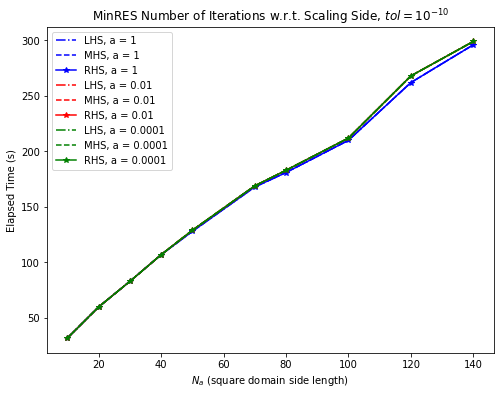

In [21]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, iter_square_LHS_1, '-.b', Na_array, iter_square_MHS_1, '--b', Na_array, iter_square_RHS_1, '-*b', 
         Na_array, iter_square_LHS_2, '-.r', Na_array, iter_square_MHS_2, '--r', Na_array, iter_square_RHS_2, '-*r',
         Na_array, iter_square_LHS_3, '-.g', Na_array, iter_square_MHS_3, '--g', Na_array, iter_square_RHS_3, '-*g')
      
plt.title(r"MinRES Number of Iterations w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 1", "RHS, a = 1", 
            "LHS, a = 0.01", "MHS, a = 0.01", "RHS, a = 0.01", 
            "LHS, a = 0.0001", "MHS, a = 0.0001", "RHS, a = 0.0001"])


## Time per Iteration plots

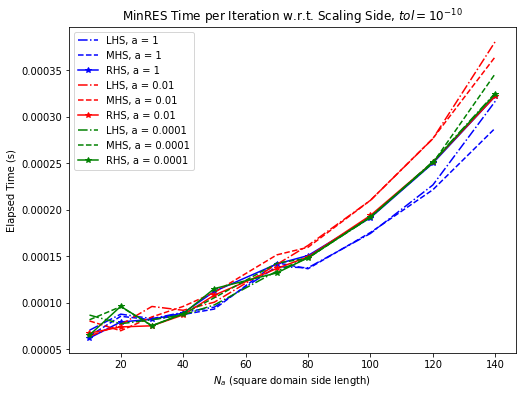

In [22]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_LHS_1/iter_square_LHS_1, '-.b', Na_array, time_square_MHS_1/iter_square_MHS_1, '--b', Na_array, time_square_RHS_1/iter_square_RHS_1, '-*b', 
         Na_array, time_square_LHS_2/iter_square_LHS_2, '-.r', Na_array, time_square_MHS_2/iter_square_MHS_2, '--r', Na_array, time_square_RHS_2/iter_square_RHS_2, '-*r',
         Na_array, time_square_LHS_3/iter_square_LHS_3, '-.g', Na_array, time_square_MHS_3/iter_square_MHS_3, '--g', Na_array, time_square_RHS_3/iter_square_RHS_3, '-*g')
    
plt.title(r"MinRES Time per Iteration w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 1", "RHS, a = 1", 
            "LHS, a = 0.01", "MHS, a = 0.01", "RHS, a = 0.01", 
            "LHS, a = 0.0001", "MHS, a = 0.0001", "RHS, a = 0.0001"])


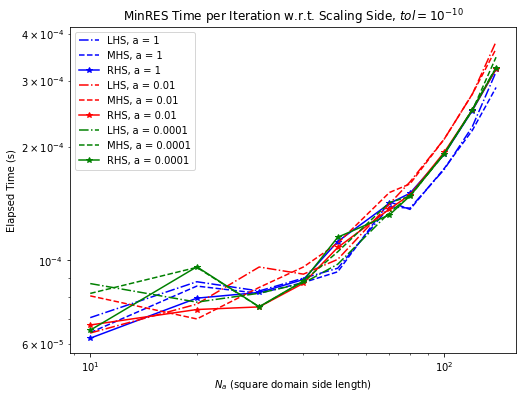

In [23]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_LHS_1/iter_square_LHS_1, '-.b', Na_array, time_square_MHS_1/iter_square_MHS_1, '--b', Na_array, time_square_RHS_1/iter_square_RHS_1, '-*b', 
         Na_array, time_square_LHS_2/iter_square_LHS_2, '-.r', Na_array, time_square_MHS_2/iter_square_MHS_2, '--r', Na_array, time_square_RHS_2/iter_square_RHS_2, '-*r',
         Na_array, time_square_LHS_3/iter_square_LHS_3, '-.g', Na_array, time_square_MHS_3/iter_square_MHS_3, '--g', Na_array, time_square_RHS_3/iter_square_RHS_3, '-*g')
    
plt.title(r"MinRES Time per Iteration w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 1", "RHS, a = 1", 
            "LHS, a = 0.01", "MHS, a = 0.01", "RHS, a = 0.01", 
            "LHS, a = 0.0001", "MHS, a = 0.0001", "RHS, a = 0.0001"])


# RMS Errors

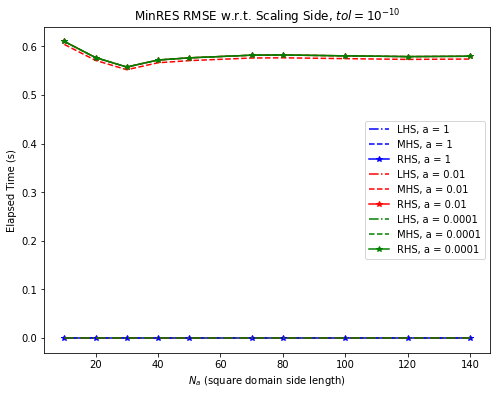

In [24]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, e_RMS_square_LHS_1, '-.b', Na_array, e_RMS_square_MHS_1, '--b', Na_array, e_RMS_square_RHS_1, '-*b', 
         Na_array, e_RMS_square_LHS_2, '-.r', Na_array, e_RMS_square_MHS_2, '--r', Na_array, e_RMS_square_RHS_2, '-*r',
         Na_array, e_RMS_square_LHS_3, '-.g', Na_array, e_RMS_square_MHS_3, '--g', Na_array, e_RMS_square_RHS_3, '-*g')
    
plt.title(r"MinRES RMSE w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 1", "RHS, a = 1", 
            "LHS, a = 0.01", "MHS, a = 0.01", "RHS, a = 0.01", 
            "LHS, a = 0.0001", "MHS, a = 0.0001", "RHS, a = 0.0001"])


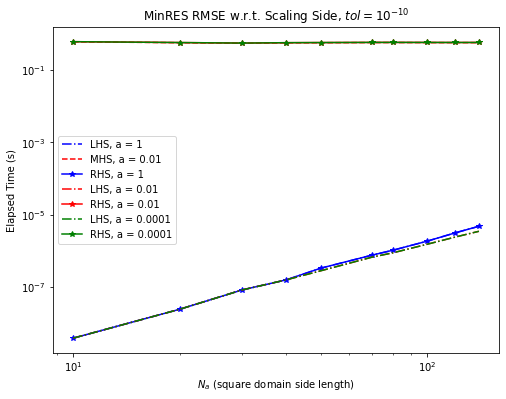

In [28]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, e_RMS_square_LHS_1, '-.b', Na_array, e_RMS_square_MHS_2, '--r', Na_array, e_RMS_square_RHS_1, '-*b', 
         Na_array, e_RMS_square_LHS_2, '-.r', Na_array, e_RMS_square_RHS_2, '-*r',
         Na_array, e_RMS_square_LHS_3, '-.g', Na_array, e_RMS_square_RHS_3, '-*g')
    
plt.title(r"MinRES RMSE w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 0.01", "RHS, a = 1", "LHS, a = 0.01", "RHS, a = 0.01", "LHS, a = 0.0001", "RHS, a = 0.0001"])


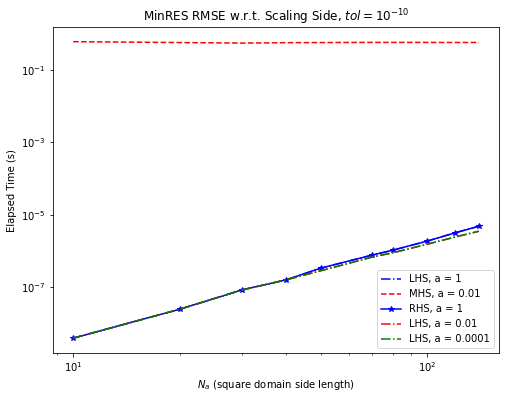

In [29]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, e_RMS_square_LHS_1, '-.b', Na_array, e_RMS_square_MHS_2, '--r', Na_array, e_RMS_square_RHS_1, '-*b', 
         Na_array, e_RMS_square_LHS_2, '-.r', Na_array, e_RMS_square_LHS_3, '-.g')
    
plt.title(r"MinRES RMSE w.r.t. Scaling Side, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["LHS, a = 1", "MHS, a = 0.01", "RHS, a = 1", "LHS, a = 0.01", "LHS, a = 0.0001"])



# Takeaway

Keeping error reduction in mind, it is most advantagueous to scale the LHS, so incorporating the coefficient of $a^{-2}$ within the matrix $\bf A$ will be beneficial.